In [33]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, lil_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim
from torch.autograd import Variable

In [34]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def icosahedral_bonds(): #12 vertices
    """
    Defines the connectivity of a true 12-vertex icosahedral molecular structure.
    
    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
        (0, 2), (0, 4), (0, 5), (0, 8), (0, 9),
        (1, 3), (1, 6), (1, 7), (1, 10), (1, 11),
        (2, 6), (2, 7), (2, 8), (2, 9), (3, 4),
        (3, 5), (3, 10), (3, 11), (4, 5), (4, 8),
        (4, 10), (5, 9), (5, 11), (6, 7), (6, 8),
        (6, 10), (7, 9), (7, 11), (8, 10), (9, 11)
    ]
    return bonds


def transverse_field_ising_icosahedral(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on an icosahedral molecular structure.
    
    Parameters:
        N (int): Number of spins (should match the icosahedral molecule, typically N=20).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 12:
        raise ValueError("Icosahedral molecules typically have N = 12 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def transverse_field_ising_icosahedral_dense(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model in dense format.
    
    Parameters:
        N (int): Number of spins.
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (np.ndarray): The Hamiltonian matrix in dense format.
    """
    # Pauli matrices
    X = pauli_x()
    Z = pauli_z()
    I = np.eye(2)
    
    # Initialize the Hamiltonian
    H = np.zeros((2**N, 2**N), dtype=np.float64)

     # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

#######################################################################################################################

def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho

def entanglement_entropy(psi, subsystem_size, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = partial_trace_qubit(psi_matrix, list(range(subsystem_size)), [2]*total_size)  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem_size, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = partial_trace_qubit_torch(psi_matrix, list(range(subsystem_size)), [2] * total_size)  # Partial trace over B

    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy


def entanglement_entropy_qutip(psi, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, list(range(total_size//2)))
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

# Define the linear combination function
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

In [35]:
N = 12  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_icosahedral(N, J, h)

# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

Eigenvalues of H: [-37.9456425  -33.85228906 -33.85228906 ...  36.38287836  40.95956435
  41.28675302]


In [36]:
def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims):
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        transposed_Q = reshaped_Q.transpose(sel + qtrace)
        vmat = transposed_Q.reshape([np.prod(dkeep), np.prod(dtrace)])
        #print("vmat", vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
        #print("rhomat", rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        transposed_Q = reshaped_Q.transpose(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        reshaped_transposed_Q = transposed_Q.reshape([np.prod(dtrace), np.prod(dtrace), np.prod(dkeep), np.prod(dkeep)])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        rhomat = np.trace(reshaped_transposed_Q)
        #print("rhomat", rhomat.shape)
    return rhomat

In [40]:
# 4/5 spins rdm - qutip

min_eigenvalues = []
min_rdms =[]
rdm_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    min_eigenvector_qobj = Qobj(min_eigenvector, [[2]*N])
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    #keep_qubits = [2, 8, 4, 5, 9] # pentagon around 0
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace(min_eigenvector_qobj, keep_qubits)
    #traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced)
    min_eigenvalues.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms.append(traced_out_density_matrix_dense) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues.append(eigenvalues_traced)

  0%|          | 0/4096 [00:00<?, ?it/s]


NotImplementedError: ('No Dual, Ket, Bra...', ([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]],))

ValueError: x and y must be the same size

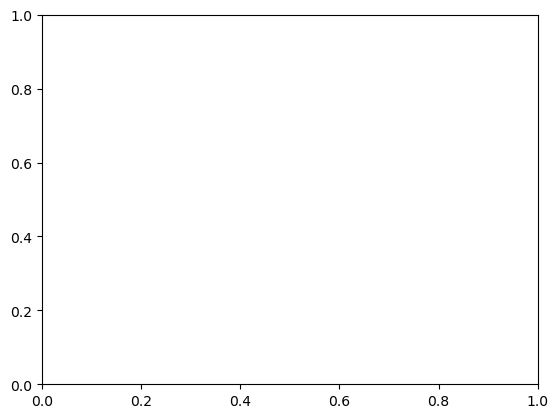

In [39]:
#qutip

# Define the threshold
threshold = 1e-16
min_eigenvalues = np.array(min_eigenvalues)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues), color=colors, s=1)

# Set y-scale to log and manually define the ticks
#plt.yscale("log")
# plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel(r"$\lambda_{\text{min}}$ of rdm")
plt.yscale("log")
#plt.xlim(5,10)
#plt.ylim(10**-19, 10**-16)
# plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [41]:
# 4/5 spins rdm - numpy

min_eigenvalues = []
min_rdms =[]
rdm_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    #density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    #keep_qubits = [2, 8, 4, 5, 9] # pentagon around 0
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace_numpy(min_eigenvector, keep_qubits, [[2]*N, [2]*N])
    #traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[2]*N, [2]*N])

    # Convert the result back to a dense matrix if needed
    #traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    #eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues.append(eigenvalues_traced)

  0%|          | 0/4096 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 4096 into shape (2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2)

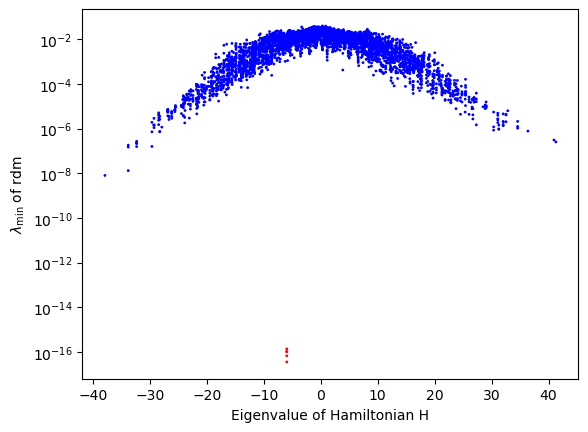

In [29]:
#numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues = np.array(min_eigenvalues)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues), color=colors, s=1)

# Set y-scale to log and manually define the ticks
#plt.yscale("log")
# plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel(r"$\lambda_{\text{min}}$ of rdm")
plt.yscale("log")
#plt.xlim(5,10)
#plt.ylim(10**-19, 10**-16)
# plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [30]:
def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims):
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print("vmat", vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print("rhomat", rhomat.shape)

    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        #print("rhomat", rhomat.shape)
    return rhomat

In [31]:
# 4/5 spins rdm - torch

min_eigenvalues_to = []
min_rdms_to = []
rdm_eigenvalues_to = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.complex64)
    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())

    # Trace out qubits
    # keep_qubits = [2, 8, 4, 5, 9] # pentagon around 0
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace_torch(density_matrix, keep_qubits, [[2] * N, [2] * N])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = torch.min(eigenvalues_traced).item()
    min_eigenvalues_to.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_to.append(traced_out_density_matrix.detach().cpu().numpy())  # store the scarred rdms - step needed for optimization
        rdm_eigenvalues_to.append(eigenvalues_traced.detach().cpu().numpy())

100%|██████████| 4096/4096 [15:01<00:00,  4.54it/s]


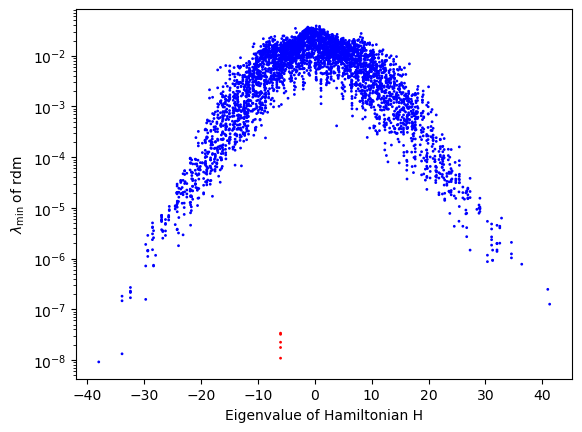

In [32]:
#torch

# Define the threshold
threshold = 1e-16
min_eigenvalues_to = np.array(min_eigenvalues_to)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_to if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues_to]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_to), color=colors, s=1)

# Set y-scale to log and manually define the ticks
#plt.yscale("log")
# plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel(r"$\lambda_{\text{min}}$ of rdm")
plt.yscale("log")
#plt.xlim(5,10)
#plt.ylim(10**-19, 10**-16)
# plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()